## Apply PCA to gene dependencies

Principal component analysis (PCA) is a commonly-used dimensionality reduction method that finds components that explain orthogonal variation in the data in a descending fashion.

We apply it to GeneEffect scores here and save latent representations (PCA components) for downstream comparative analyses (to compare with BetaVAE).

In [3]:
import sys
import pathlib
import pandas as pd
import plotnine as gg
from sklearn.decomposition import PCA

sys.path.insert(0, "../utils/")
from data_loader import load_model_data

In [4]:
data_directory = pathlib.Path("../0.data-download/data")
dependency_file = pathlib.Path(f"{data_directory}/CRISPRGeneEffect.parquet")
gene_dict_file = pathlib.Path(f"{data_directory}/CRISPR_gene_dictionary.parquet")

output_dir = pathlib.Path("results")
pca_output_file = pathlib.Path(f"{output_dir}/pca_latent.parquet.gz")
output_pca_weights_file = pathlib.Path(f"{output_dir}/PCA_weight_matrix_gsea.parquet")

In [5]:
pca_components = 50

In [6]:
# Load data
dependency_df, gene_dict_df = load_model_data(dependency_file, gene_dict_file)

(1150, 18444)


# Perform PCA

In [7]:
pca = PCA(n_components=pca_components)
pca.fit(dependency_df.drop(columns=["ModelID"]))

PCA(n_components=50)

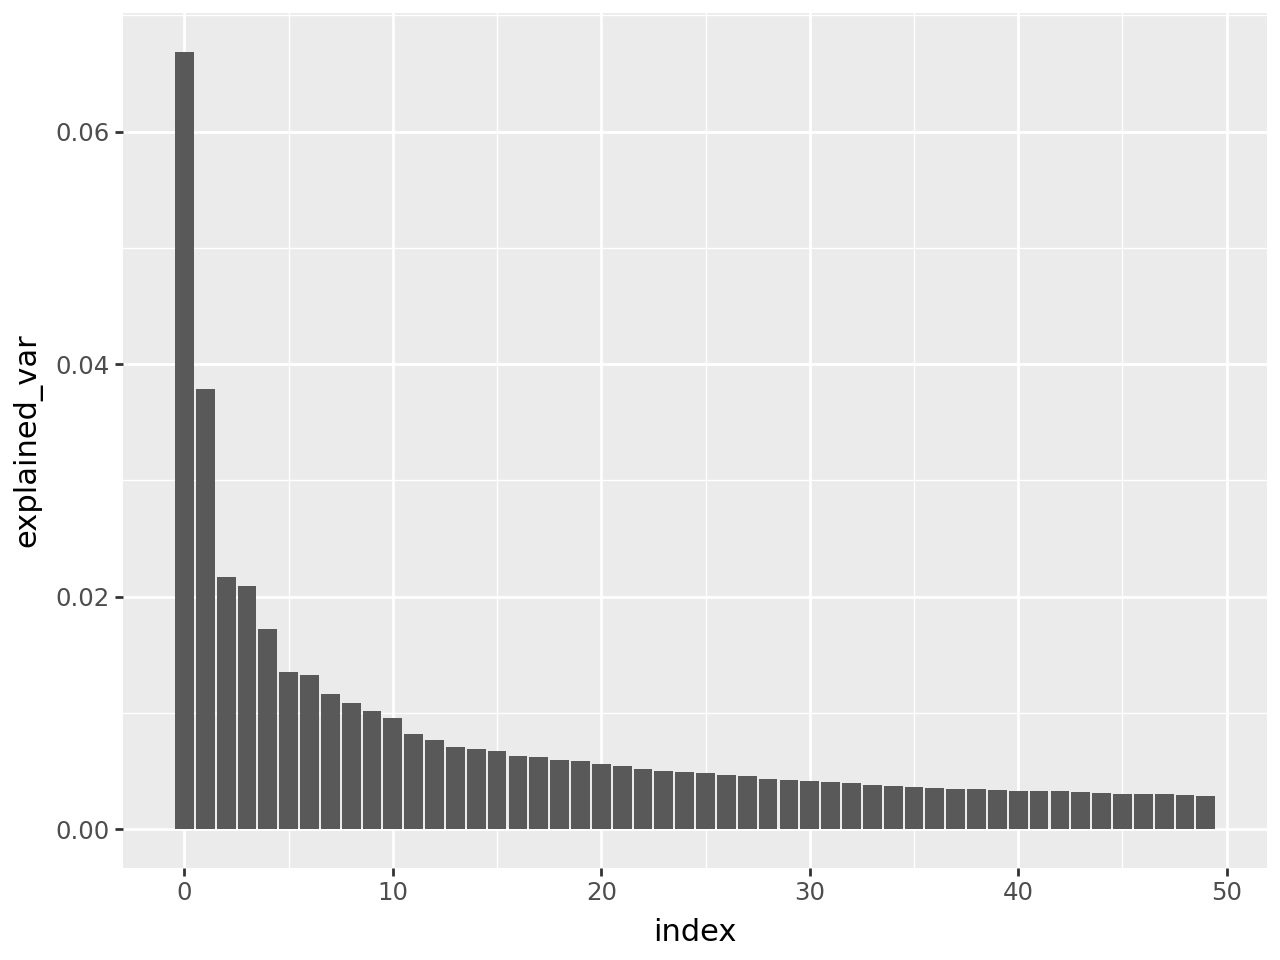

In [8]:
# Output explained variance and quickly visualize
explained_var = pd.DataFrame(pca.explained_variance_ratio_, columns=["explained_var"]).reset_index()

(
    gg.ggplot(explained_var, gg.aes(x="index", y="explained_var"))
    + gg.geom_bar(stat="identity")
)

In [9]:
# Transform models into pca space
dependency_df_transformed = pd.DataFrame(
    pca.transform(dependency_df.drop(columns=["ModelID"]))
)

# Recode column space and add back model IDs
dependency_df_transformed.columns = [f"PCA_{x}" for x in range(0, dependency_df_transformed.shape[1])]
dependency_df_transformed = pd.concat([dependency_df.loc[:, "ModelID"], dependency_df_transformed], axis="columns")

dependency_df_transformed.to_parquet(pca_output_file, index=False)

print(dependency_df_transformed.shape)
dependency_df_transformed.head(3)

TypeError: __cinit__() got an unexpected keyword argument 'sep'

In [ ]:
# Obtain weights, which can be used in GSEA
pca_weights = pd.DataFrame(pca.components_, columns=dependency_df.drop(columns=["ModelID"]).columns.tolist()).transpose()
pca_weights.columns = [f"PCA_{x}" for x in range(0, pca_weights.shape[1])]

pca_weights = pca_weights.reset_index().rename(columns={"index": "genes"})

pca_weights.to_parquet(output_pca_weights_file, index=False)

print(pca_weights.shape)
pca_weights.head(3)

(2732, 51)


,genes,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,TIGD3,0.010714,0.001402,0.002633,-0.004015,0.009681,-0.003124,-0.001792,0.008347,-0.009286,...,-0.004950,0.006507,-0.007249,0.002603,0.000796,0.002430,-0.009665,0.004099,0.008760,0.003690
1,EXOSC5,0.022203,0.026663,0.001951,-0.001086,-0.003433,0.021470,-0.013724,-0.010994,0.004329,...,0.000890,-0.000323,0.008395,0.004357,0.008282,-0.002010,0.005371,-0.002132,-0.000260,-0.021927
2,XPOT,-0.004562,0.000938,0.013140,0.000832,0.006934,-0.009125,-0.010528,-0.007316,0.004086,...,-0.013424,0.020678,-0.011322,-0.005141,0.003696,0.002042,0.019125,0.036072,0.017552,0.019537
